In [1]:
# Import some libraries from python and set some defaults
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import sys
import os
import time
sys.path.append(os.getcwd())
from scipy import stats
import pickle
import copy
#set the font size for plots
plt.rcParams.update({'font.size': 17})
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
rc('animation', html='html5')

In [2]:
from ipywidgets import widgets, interact, interactive, fixed
from ipywidgets import Button, HBox, VBox
import shelve
assessmentName="Percolation";
import os

def get_last_value(key):
    if os.path.isfile('.choices.shelve') or os.path.isfile('.choices.shelve.dir'):
        s=shelve.open('.choices.shelve')
        return s.get(key,None)
    return None


class myRadioButton:
    def __init__(self,name,description,options):
        self.name=name
        self.options=options
        self.description=description
    def getWidget(self):
        def on_value_change(change):
            s=shelve.open('.choices.shelve')
            key=self.getKey()
            s[key]=change['new']
            s.close()

        self.widget=widgets.RadioButtons(
            options=self.options,
            value=get_last_value(self.getKey()),
            description=self.description,
            disabled=False
        )
        self.widget.observe(on_value_change, names='value')

        return self.widget
    def getKey(self):
        return '{0}_{1}'.format(assessmentName,self.name)
        
        
def on_value_change(change):
                s=shelve.open('.choices.shelve')
                key='{0}_{1}_{2}'.format(assessmentName,self.name,i)
                s[key]=change['new']
                s.close()

def make_value_change_fn(assessmentName,name,i):
        def fn(change):
            s=shelve.open('.choices.shelve')
            key='{0}_{1}_{2}'.format(assessmentName,name,i)
            s[key]=change['new']
            s.close()
        return fn

class myCheckBoxSet:
    def __init__(self,name,description,options):
        self.name=name
        self.options=options
        self.description=description
    def getWidget(self):
        keys=['{0}_{1}_{2}'.format(assessmentName,self.name,i) for i in range(len(self.options))]    
        self.widgets=[ widgets.Checkbox(value=get_last_value(key),
    description=o,
    disabled=False
        ) for key,o in zip(keys,self.options)]
        
        txt=widgets.HTMLMath(
            value=self.description,
            placeholder='',
            description='',
        )

        
        self.widget=VBox([txt]+self.widgets)
        for i,w in enumerate(self.widgets):
            w.observe(make_value_change_fn(assessmentName,self.name,i), names='value')

        return self.widget
import mywidgets

# Preamble: workshop notebooks

Work through this notebook cell by cell.

When working on your solution, you can save the notebook as many times as you like. You can also submit 
as many times as you like. In fact, it is a good idea to save and submit often.

**Validate** the notebook before submitting. Use the *validate* button in the browser

**Do not copy or delete one of the original cells**. Doing so means you cannot validate the notebook.
If required, *create a new cell*, and copy the *contents* of another cell.


**Only the last submission before the deadline** will be marked.
Note that you have to **submit** at least once for your work to be marked.

Please note that is a **summative assignment** and will determine your marks for Scientific Computing.
This also means that you are **not allowed to collaborate on this assignment**: it should all be your own work.



The notebook contains cells with code. Some of the code is (intentionally) missing. Please insert appropriate code below the line 'YOUR CODE HERE'. Cells which do not contain any 'YOUR CODE HERE' lines will allow you to test your code; if they return an error there is something wrong with your implementation; if they do not return an error your code might be correct (it is unfortunately not possible to check for every possible error).

Note:

simply add numerical value in a dropbox for it to get marked

when asked for true/false in a box:

ticking a box means True
not ticking (or ticking an even number of times) yields False


# Workshop 8: Cluster growth and percolation

## 1) Cluster growth

### The cell below defines the Cluster class. Complete the methods that are only partially implemented.

You can the use the later cells to test your implementation.

Completing the class `Cluster` is the main aim of the first part. Some parts of the methods need to be completed.
The cells below take you through this, one method at a time. There are also some cells to verify your implementation.

The main components of an instance of the class are:
 - ndim: the dimension of the cluster. We only examine the special case of ndim=2
 - periodic: if True, impose periodic boundary conditions, else, impose isolated boundary conditions
 - size: the extent of a cluster in any dimension
 - grid: a dictionary of positions currently occupied by the cluster, in the form of tuples
      for example ((0,1): True) if element (0,1) is part of the cluster
 - boundary: a dictionary of nearest-neighbours of cluster elements, that are **not** (yet) occupied
 - offsets: a list of all neigbours of location (0,0)
     - for ndim=2, the list of offsets is [(1,0), (-1,0), (0,1), (0,-1)]

Note that `position` is a tuple of shape `self.size`, e.g. (0,1) in 2 dimensions. For some calculations it may be useful to convert this tuple to a numpy array, for example when computing distances between two positions.
Using tuples - one of the standard python types - makes it easy to check whether a given position is inside a cluster of tuples.

"Periodic boundry conditions" means that location (0,0) neighbours locations (1,0), (0,1) but in addition also
locations $(L-1,0)$ and $(0,L-1)$, where $L$ is the linear size of the lattice. When the boundary conditions are not periodic, then the neighbours of location (0,0) are only (1,0) and (0,1). 


In [14]:
class Cluster:
    # initialize the cluster
    def __init__(self, ndim=2, size=32, random_number_seed=-1, periodic=False):
        self.size     = size             # linear extent of the lattice
        self.ndim     = ndim             # dimensionality
        self.periodic = periodic         # if True: use periodic boundary conditions, else use isolated boundary conditions
        self.grid     = {}               # the grid will store all the tuples that correspond to occupied locations
        self.boundary = None             # to be initialized 
        
        ''' Initialize the random number generator provided random_number_seed is > 0
        When initialized, the random sequence will be the same sequence every time you run the code
             This can be useful for debugging your code.
        If uninitialized, you'll get a different sequence every time. 
             This can be used if you want to calculate average properties of clusters, siince different runs
             will result in different clusters ''' 
        if random_number_seed > 0:
            np.random.seed(random_number_seed)
        else:
            np.random.seed(None)
            
        # create list of all nearest neighbours of element (0,) * ndim
        self.offsets = []
        for dim in range(self.ndim):
            offset = np.zeros(ndim, dtype=int)
            offset[dim] = 1
            self.offsets.append(tuple(offset))
            self.offsets.append(tuple(-offset))
        self.noffsets = len(self.offsets)     
            
    def element_inside(self, position):
        ''' The function return True / False depending on whether position is inside / outside the grid.
            input: location "position" to be tested (tuple)
            output: True if position is on the lattice, False if position is not on the lattice '''
        if self.periodic:
            return True                                     # all positions are part of the lattice
        sp = np.array(position)
        return (sp >= 0).all() and (sp < self.size).all()   # test whether each coordinate is in the range [0, L[
                                                            # where L=self.size is the size of the lattice

    def periodic_wrap(self, position):
        ''' This function periodically wraps "position" on the grid if self.periodic
            input: location "position" to be wrapped (tuple)
            output: wrapped value of position (tuple) '''
        if self.periodic:
            return tuple(np.array(position) % self.size)
        else:
            return position
            
        
    def element_add(self, position):
        ''' This routine adds the element at location "position" (a tuple) to the cluster
                if the element is already part of the cluster, raise an exception
            If periodic=True:  wrap position periodically before inserting element
            If periodic=False: raise exception if element is outside the grid boundaries '''
        
        # convert tuple to array to perform arithmetic
        pos = np.array(position)

        if self.periodic:
            pos  = (pos + 2 * self.size) % self.size     # apply periodic boundary conditions
            
        if(self.element_inside(pos)):
            if tuple(pos) in self.grid:
                print(" ++ element_add, Position = ", pos)
                raise Exception("Element is already in cluster")
            else:
                self.grid[tuple(pos)] = True
        else:
            print(" ++ element_add, Position = ", pos)
            raise Exception("Element is outside of grid")
    
    def element_neighbours(self, position):
        ''' This function returns the list of all nearest-neighbours of a given position, that are inside the grid.
            input:   position: location for which we want a list of nearest-neighbours (tuple)
            output:  neighbours: a list of tuples that are valid neighbours of position (tuples)'''

        # consistency check:
        if len(position) != self.ndim:
            raise Exception(" Error: this position does not have the right dimension")
            
        ''' You may want to use self.offsets to create the list of all nearest-neighbours positions.
         Note: Adding tuples does not give you the offset that is required. Instead, you must
               convert the tuple to an array to compute the offset position first, for example as
                   new_neighbour = np.asarray(position) + offset,
               but make sure to convert it back to a tuple before adding it to the list of neighbours
                   neighbours.append(new_neighbour)
               You must also make sure that new_neighbour is on the grid, and, if periodic, is correcty wrapped '''
        neighbours = []
        # YOUR CODE HERE
        for i in range(len(self.offsets)):
            new_neighbour = np.asarray(position)+self.offsets[i] #set the new neighbours
            if self.element_inside(new_neighbour): #check element inside
                if self.periodic ==True:
                    new_neighbour=self.periodic_wrap(new_neighbour)
                neighbours.append(tuple(new_neighbour))
    
        return neighbours

    def distance(self, position1, position2):
        ''' This function returns the distance (float) between the tuples at position1 and position2 '''
        # consistency check
        if len(position1) != self.ndim:
            raise Exception("not a valid position 1 in distance")
        if len(position2) != self.ndim:
            raise Exception("not a valid position 2 in distance")
        
        # Again we convert the tuple to an array to perform the calculation
        p = np.asarray(position1)
        q = np.asarray(position2)
        distance = 0
        for i in range(len(p)):
            dx = np.abs(p[i]-q[i])
            if self.periodic:
                if dx > self.size/2:
                    dx = self.size - dx
            distance += dx * dx
        distance = np.sqrt(distance)
        return distance
    
    def element_distances(self, position):
        ''' This function returns all the distances from each element of the cluster, 
            to the given location "position" '''
        distance = {}
        for element in self.grid:
            distance[element] = self.distance(element, position)
        return distance
    

        
    '''
    #########################################################################################################
    #      The three methods below implement the three models for cluster growth that were discussed in the #
    #     lecture namely Eden, DLA and Random.                                                              #
    #########################################################################################################
    '''
    

    def Eden(self):
        ''' Eden model for cluster growth
          The algorithm for adding an element is as follows. Starting from a seed (single element)
             - pick randomly any unoccupied site that is a nearest neighbour of an element already in the cluster
             - add it to the cluster
        The method below should add 1 element to the cluster based on this algorithm        
        The first time Eden is invoked, we create a list of empty sites that neighbour the cluster.
        This dictionary is called self.boundary, 
        Each time Eden is called, we update the dictionary, adding new boundary elements and removing
        none-boundary elements'''
        if self.boundary == None:
            self.boundary = {}
            # iterate over all neighbours of all elements in the current cluster.
            # if the neighbour is not in the cluster, and not in self.boundary, add it to self.boundary
            # YOUR CODE HERE
            for element in self.grid: #find element in greed
                for neighbour in self.element_neighbours(element):
                    if neighbour not in self.grid:
                        if neighbour not in self.boundary:
                            self.boundary[self.periodic_wrap(neighbour)] = True

        # pick at random an element of self.boundary, and add this element to the cluster
        # there are several valid ways of picking an element to add
        # once you've picked an element to add, use self.element_add(element) to add it to the cluster
        # make sure you call the element "element"
        # YOUR CODE HERE
    
        rand=np.random.choice(len((self.boundary.keys())))
        element=list(self.boundary.keys())[rand]
        self.element_add(element)

        # remove this element from self.boundary
        # YOUR CODE HERE
        del self.boundary[element]
        
        # add the neighbours of the element to self.boundary,
        #      provided they are not in the cluster and not already in the boundary

        for neighbour in self.element_neighbours(element):
            if neighbour not in self.grid:
                if neighbour not in self.boundary:
                    self.boundary[self.periodic_wrap(neighbour)] = True

        # return current number of elements in the boundary
        return len(self.boundary)

    def DLA(self, centre, radius, edge):
        ''' DLA model for generating a cluster. The method for adding an element to a DLA cluster is as follows.
            Start a random walk at a distance "radius" away from the seed of the cluster. The seed is at location "centre"
            Terminate the walk, if either the walker:
              - Hits the cluster. When this happens, add the previous step of the walk to the cluster
              - Crosses the edge, i.e. reaches a distances > edge from the centre
              
              
            The DLA method below adds an element to a cluster and return "track". 
            
            Track is a list of all sites visited in this particular random walk.
        
            input:
              centre: the original centre of the cluster (tuple)
              radius: the distance to the centre from which we start the random walk (float)
              edge:   the maximum distance from the centre, before we terminate the walk (float)
            Note that once again, we use arrays - rather than tuples - to perform the calculation'''
        
        # location of the centre - converted to array to perform arithmetic
        start     = np.asarray(centre)
        
        # we will generate an offset from the starting position initially in polar coordinates (rad, phi)
        # rad is the distance from the starting position, for which we take radius
        # phi is the polar angle, and is in the range [0, 2pi[
        # the Cartesian coordinates are then
        #    x = r cos(phi); y=r sin(phi) (but converted to integers so that this is a position on the grid)
        # once the offset is computed, we convert it to Cartesian (x,y) coordinates
        rad = radius
        if(rad < 1):
            rad = 1
        phi = 2 * np.pi * np.random.random()  # angle uniform in [0, 2pi[
        x   = rad * np.cos(phi)
        ix  = int(np.rint(x))      # convert to integer offset
        y   = rad * np.sin(phi)
        iy  = int(np.rint(y))      # convert to integer offset
        dr  = np.sqrt(x*x+y*y)
        
        # add starting offset
        start[0] += ix
        start[1] += iy
        start     = tuple(start)
        cont      = True
        
        # track stores all the locations that the random walk visits
        track   = []
        track.append(start)
        step    = start   # the random walk steps from the current step, "step", to the next step, "next_step"
        while cont:
            # continue walking as long as cont = True
            #print(1)
            # take a random step, from step to next_step
            # Hint: use RandomStep, implemented below, or write your own
            # YOUR CODE HERE

            next_step=self.RandomStep(step)
            # If any neighbour of next_step is in the cluster, then:
            #    - add next_step to cluster
            #    - add next_step to track
            #    - set cont = False, to end walk
            # use self.element_add to add the element to the cluster
            # If no neighbour is in the cluster, keep stepping unless the walker wandered too far from the centre
            # YOUR CODE HERE

            for ele in self.element_neighbours(next_step):
                if ele in self.grid:
                    if next_step not in self.grid:
                        if self.element_inside(next_step):
                            self.element_add(next_step)
                    track.append(next_step)
                    cont=False
                    break
            # if cont is True, we need to check if walker is still in the allowed region
            #     if distance to centre > edge: put cont = False, add element to track, and end walk
            #     if distance to centre < edge: cont = True
            #         - add next_step to track
            #         - put step = next_step
            #         - continue walk
            # YOUR CODE HERE
            if cont == True:
                if self.distance(next_step,centre) > edge:
                    cont=False
                    track.append(next_step)
                    break
                if self.distance(next_step,centre) < edge:
                    cont=True
                    track.append(next_step)
                    step=next_step
        # walk finished: return the track 
        # You may want to uncomment the lines below for debugging your code
        #if attach:
            #print("Walker attached to cluster at position = ", next_step)
        #else:
            #print("walker off grid")
        return track

    
    def Random(self, probability):
        ''' Random model for generating a cluster.
            This function randomly adds sites to a grid, based on comparing a uniform random number, prob,
               to the input (given) probability "probability" (float)
        
        
         input: 
            probability: desired probabikity that a site is occupied (float)
         if probability>1:  all sites are added to the cluster. 
         if probability <= 0: no sites are added.
         if 0<probability<1: for each site: if random number < probability, add element to cluster '''
        
        self.p = probability
        shape  = (self.size,) * self.ndim
        prob   = np.random.rand(*shape)
        assign = np.where(prob < probability)
        assign = np.array(assign).T
        for a in assign:
            self.element_add(a)

    ''' 
    #########################################################################################################
    The routines below are helper routines. You should not need to edit them.                                                              
    #########################################################################################################
    '''

    # Perform a single random step, starting at location "position"
    #     function returns the location of the end of the step
    def RandomStep(self, position):
        # input:
        #    position: location from where the single step starts
        # offset the step chosen randomly from the list of valid offsets
        itry      = np.random.choice(range(self.noffsets))
        offset    = self.offsets[itry]
        # once offset is chosen, the new poistion is offset from position
        new       = tuple(np.array(position) + np.array(offset))
        return self.periodic_wrap(new)

    
    # Starting from location "position", take nstep random walk steps
    def RandomWalk(self, position, nstep):
        # input:
        #   position: starting position
        #   nstep:    number of steps to perform
        # output:
        #   track: locations of the nstep steps   
        track   = []
        current = position
        for i in range(nstep):
            current  = self.RandomStep(current)
            track.append(current)
        return track
    
    # Plot the current cluster
    #   Input is the cut to plot, and, optionally, the name of the plot, and the name of the file
    #   to save the plot
    # This general routine allows you to plot clusters of any dimensionallity. If ndim>2, it will plot
    #   a 2D slice. In our case, we only generate clusters in 2 dimensions.
    def ShowCluster(self, cut, title=None, file=None):
        # extract the coordinates of the cluster specified by cut 
        xs, ys  = self.ExtractSlice(cut)
        # create the figure, and plot all cluster sites
        fig, ax = plt.subplots(figsize=(7,7))
        ax.set_aspect('equal')
        ax.set_xlim(-1, self.size)
        ax.set_ylim(-1, self.size)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        if not title == None:
            ax.set_title(title)
        ax.grid()
        ax.plot(xs,ys,'ro',alpha=0.2)[0]
        
        # save the figure
        if not file == None:
            print("Saving cluster to file: ", file)
            plt.savefig(file)
            
        fig.show()
        
 
    # Extract a slice: this is useful if the cluster is in ndim>2 dimensions
    #    cut specifies the direction to cut the cluster and extract a 2D slice
    def ExtractSlice(self, cut):
        # cut is a tuple of length self.ndim
        # the tuple should have exactly 2 elements equal to -1, which define the plane to extract
        if len(cut) != self.ndim:
            raise Exception(" cut has wrong length")
        plane = np.where(np.asarray(cut) == -1)[0]
        if len(plane) != 2:
            raise Exception(" plane has wrong dimenson ", len(plane))
        for dim in range(self.ndim):
            if dim not in plane:
                if cut[dim] < 0 or cut[dim] >= self.size:
                    raise Exception(" cut is out of range ", dim, cut[dim])
        #
        sites = []
        xs    = []
        ys    = []
        cut = np.asarray(cut)
        for site in self.grid:
            if np.all(np.logical_or(cut==-1,cut==np.asarray(site))):
                sites.append(site)
                xs.append(site[plane[0]])
                ys.append(site[plane[1]])
        return xs, ys        
                
    # This function plots a track, as generated by DLA for example, for a given random walk
    #  Input is the track and optionally, file: the name of the file to save the figure
    def ShowTrack(self, track, file=None):

        fig, ax = plt.subplots(figsize=(7,7))
        ax.set_aspect('equal')
        ax.set_xlim(-1, self.size)
        ax.set_ylim(-1, self.size)
        ax.set_xlabel("x-position")
        ax.set_ylabel("y-position")
        ax.set_title("Track of random")
        ax.grid()
        xs = []
        ys = []
        for el in track:
            xs.append(el[0]) 
            ys.append(el[1])
#        ax.plot(xs,ys,'ro',alpha=0.2)[0]
        ax.plot(xs, ys)
    
        # plot the starting position
        label = 'start'
        el = track[0]
        ax.plot(el[0], el[1], 'D', color='red',label=label)

        # plot the end position
        label = 'end'
        el = track[-1]
        ax.plot(el[0], el[1], 'D', color='cyan', label=label)
        
        ax.legend(frameon=False)
        fig.tight_layout()
        # save the figure
        if not file == None:
            print("Saving track to file: ", file)
            plt.savefig(file)
            
        plt.show()  


### The cells below, test your implementation of the methods in Cluster

If your code does not pass this cell, you should debug your implementation of `Cluster` before continuing.
There are no marks associated with these tests.

In [15]:
# initialize a small cluster
size     = 5          # size of cluster
ndim     = 2          # dimensionallity of cluster
periodic = True       # boundary condition
cluster  = Cluster(ndim=ndim, size=size, periodic=periodic) # generate instance of the cluster

# add a single element at the centre
cent = int(size/2)          # location of seed
seed = (cent,) * ndim       # seed of cluster
cluster.element_add(seed)   # we now have a cluster with 1 element, which is located at the centre

# Provided your implementation is correct, cluster.grid = {{2,2)}: True}
test = {(2,2): True}
if cluster.grid == test:
    print("That's right! -- continue")
else:
    print("you made and error in element_add")

# Using the list of offsets, add the neighbour to the right of the seed to the cluster
offset  = cluster.offsets[0]
element = tuple(np.asarray(seed) + np.asarray(offset))
print("We are adding element = ", element)
cluster.element_add(element)
test2 = {(2, 2): True, (3, 2): True}
if cluster.grid == test2:
    print("That's right! -- continue")
else:
    print("you made and error in element_add or the list of offsets")

# Test adding an element that is already in the cluster
try:
    cluster.element_add(seed)
    print(" this should not happen: element should not be added twice ")
except:
    print("That's right! -- continue")
    pass    

# Test periodic wrapping
element = (2*size, int(size/2))  # this element is outside of the grid, but we are using periodic boundary conditions
print("We are adding element = ", element)
cluster.element_add(element)
test3 = {(2, 2): True, (3, 2): True, (0, 2): True}
if cluster.grid == test3:
    print("That's right! -- continue")
else:
    print("you made and error in implementing element_add (periodic boundary conditions)")

    
    
# now test non-periodic cluster
cluster  = Cluster(ndim=ndim, size=size, periodic=False)
try: 
    cluster.element_add(element)
    print(" this should not happen: element should not be added")
except:
    print("That's right! -- continue")
    pass

That's right! -- continue
We are adding element =  (3, 2)
That's right! -- continue
 ++ element_add, Position =  [2 2]
That's right! -- continue
We are adding element =  (10, 2)
That's right! -- continue
 ++ element_add, Position =  [10  2]
That's right! -- continue


In [16]:
# This cell tests your implementation of the "element_neighbours" method"

# create a small cluster and add some elements to it
size     = 7          # size of cluster
ndim     = 2          # dimensionallity of cluster
periodic = False      # boundary condition
cluster  = Cluster(ndim=ndim, size=size, periodic=periodic)

# start with seed at centre, and add all off its neighbours
cent = int(size/2)          # location of seed
seed = (cent,) * ndim       # seed of cluster
cluster.element_add(seed)
for offset in cluster.offsets:
    element = tuple(np.asarray(seed) + np.asarray(offset))
    cluster.element_add(element)

# list all neighbours of some positions
neighbours = cluster.element_neighbours(seed)
test = [(4, 3), (2, 3), (3, 4), (3, 2)]
if neighbours == test:
    print(" That's right! -- continue")
else:
    print("you made an error in implementing element_neighbours")

 That's right! -- continue


## a) The Eden model of cluster growth

Complete implementing the Eden model in the `Cluster` class.
The growth algorithm is as follows (see lecture notes)
    - at start-up, create self.boundary - a list of all valid, empty sites that are nearest-neighbours 
    of the current cluster elements. Initially, these are the nearest neighbours of the `seed`.
    - pick randomly one of the elements in the list of boundary cells, self.boundary
        - add the element to the cluster
        - remove the element from the list of boundary sites
        - update the list of boundary sites
        
        



Saving cluster to file:  Eden.png


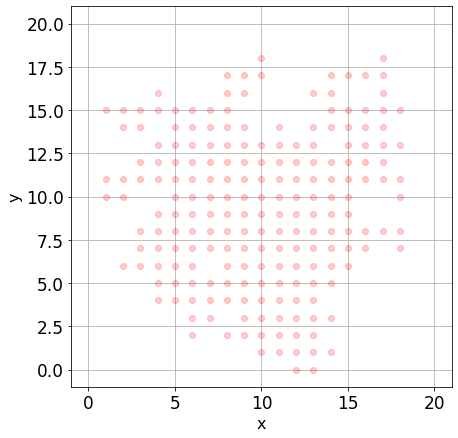

In [17]:
size     = 21         # size of cluster
ndim     = 2          # dimensionality of the cluster
periodic = False      # boundary condition
cluster  = Cluster(ndim=ndim, size=size, random_number_seed = 1, periodic=periodic)
cent     = int(size/2)
seed     = (cent,) * ndim       # seed of cluster

cluster.element_add(seed)
nsites = 200               # add nsites=200 elements to the Eden cluster
for i in range(nsites):
    cluster.Eden()

# Use ShowCluster to visualize the cluster. Set cut=[-1, -1] to show the full 2D cluster
cut   = [-1, -1]
file  = 'Eden.png'
# YOUR CODE HERE
### Nothing to add - simply run this cell
title = 'Eden cluster'
cluster.ShowCluster(cut, file=file)


You may want to compare to the image below

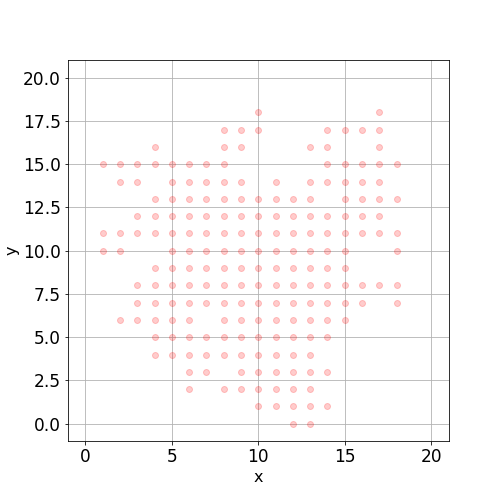

### Compute the fractal dimension of an Eden cluster


In the next cell:
 - Generate an Eden cluster with the specified parameters of size, ndim, periodic, and location of starting seed.
 - Compute the distance of each element to the seed
 - Sort the distance in ascending order
 - Plot the enclosed mass, $M(\le r)$, as a function of radius $r$. Assume that each element has mass = 1. (In effect this amounts to counting the number of elements as a function of distance to the seed. Please do not count the seed).
 - Use this to estimate the fractal dimension $d$, from $M(\le r)\propto r^d$ (ignore the seed). Do so by fitting a linear relation of the form $\log M(\le r)=A + d \log(r)$ to the plot.
 
 
Hint: for large $r$, say $r\ge 10$, you'll see that the $M(r)$ turns over. This is not surprising, since the cluster has finite size. Therefore once $r$ becomes too large, $M(r)$ becomes a constant. 

Because of this, you don't want to fit the relation $\log M(\leq r)\propto \log r$ to determine $d$ for all values of $r$ for which you have occupied sites. Instead, **fit the relation only for $1<r< 10$**. 

In conclusion, compute $M(\leq r)$ for the Eden cluster, then fit the parameters $A$ and $d$ of the relation

$$M(\leq r) = A\,r^d\,,$$

to your result, over the range $r\in ]1, 10[$. You may want to use a built-in linear regression routine such as ``stats.linregress`` to perform the fit.

1.8552948410179797 0.5401826034784301


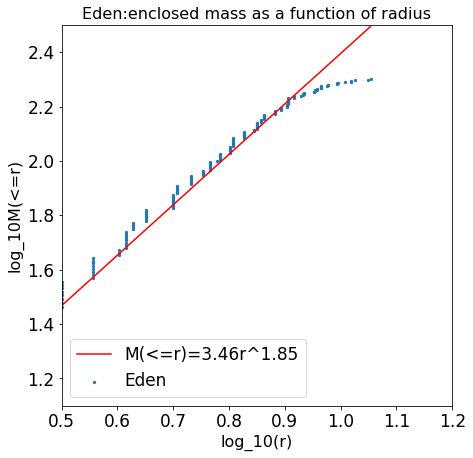

In [18]:
size       = 101                  # linear extent of lattice
ndim       = 2                    # dimensionality of lattice
periodic   = False                # non-periodic boundary conditions
cent       = int(size/2)          # location of seed
seed       = (cent,) * ndim       # seed of cluster
nsites     = 200                  # number of sites to add


# for each element of the cluster, compute the distance to the seed
# sort these distances from small to large, and remove the first element (the seed, which has distance = 0, of course)
# assume each element has a mass equal to one, and compute the enclosed mass, M(<r), where M is mass enclosed within radius r
# Estimate the fractal dimension, d, using M=M_0 r^d
#   - hint: you may want make linear fit to log M = A + B log r, which has slope is B=d
#           notice that the relation starts to bend (and hence is no longer linear) for large r - you may
#           want to restrict the fit to stay away from the boundary
#           I used stats.linregress to perform the linear fit
#  plot log M(<r) versus log(r), and overplot your fit. Make sure you add a legend and label the axes

# approximate marking scheme
# plot has correctly labelled axes:                    2 marks
# results from the Eden model are plotted and look OK: 4 marks
# linear fit is over plotted and looks OK:             2 marks
# the plot has a legend:                               2 marks

fig, ax = plt.subplots(1, 1, figsize=(7,7))
# YOUR CODE HERE
cluster  = Cluster(ndim=ndim, size=size, random_number_seed = 1, periodic=periodic)
cluster.element_add(seed)
origin=list(cluster.grid.keys())[0]
for i in range(nsites):
    cluster.Eden()
dist_ori=list(cluster.element_distances(origin).values())
dist_ori.remove(0.0)
dist_sorted=sorted(dist_ori)

m=[]
temp=[]
for j in range(len(dist_sorted)):
    
    m.append(j+1)
slo=0
c=0
x=np.log10(dist_sorted)
y=np.log10(m)
res = stats.linregress(x, y)
slo=res.slope
c=res.intercept
print(slo,c)
ax.scatter(np.log10(dist_sorted),np.log10(m), label='Eden', s=5)
ax.set_xlim(0.5,1.2)
ax.set_ylim(1.1,2.5)
ax.set_xlabel(r'log_10(r)')
ax.set_ylabel(r'log_10M(<=r)')
ax.set_title('Eden:enclosed mass as a function of radius')
ax.plot(np.log10(dist_sorted),slo*np.log10(dist_sorted)+c,label='M(<=r)=3.46r^1.85', color='red')
plt.legend()
plt.show()

You may want to compare to the plot below. If you use a different random number seed, you'll get a different cluster and the parameters $A$ and $B$ of the fit will differ.

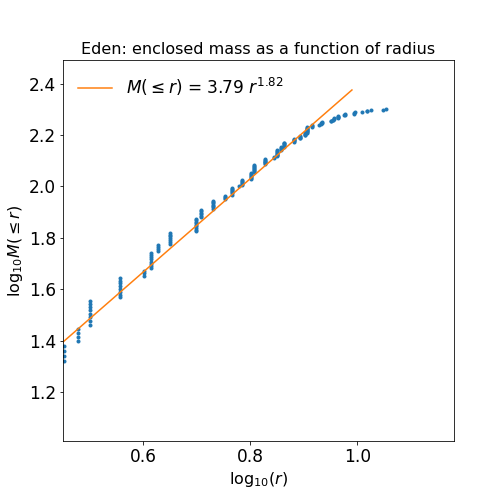

Now generate 2000 realisations of an Eden cluster with the parameters as used before, ndim=2, nsites=200.

**Make sure that each cluster is different by using a different random seed for the random number generator.**

Compute the fractal dimension $d$, defined as $M(\leq)\propto r^d$, where $M(\leq r)$ is the mass enclosed with radius $r$, fitting to the range $r\in ]1, 10[$ for each. (The notation`],[` means that you do **not** include the limits, i.e use $r>1$ and $r<10$) for each of the realisations.

Plot a histogram of the values of $d$, making sure the histogram is normalised to unity. 

Compute the mean value, $\langle d\rangle$, of $d$ and the standard deviation of $d$.
Over plot a Gaussian with the same mean and standard deviation.
Plot a vertical dashed line with horizontal value equal to $\langle d\rangle$.

Add a legend to make clear what has been plotted.

In [19]:

# Approximate marking scheme
# axes are correctly labelled:             2 marks
# histogram of numerical values looks OK:  5 marks
# Gaussian is over ploted and looks OK:    5 marks
# Mean value is indicated by a line:       1
# Plot has a legend:                       2 marks

# YOUR CODE HERE
start_time = time.time()
slopes=[]
for i in range(2000):
    cluster  = Cluster(ndim=ndim, size=size, random_number_seed = i, periodic=periodic)
    cluster.element_add(seed)
    origin=list(cluster.grid.keys())[0]
    for i in range(nsites):
        cluster.Eden()
    dist_ori=list(cluster.element_distances(origin).values())
    dist_ori.remove(0.0)
    dist_sorted=sorted(dist_ori)

    m=[]
    temp=[]
    for j in range(len(dist_sorted)):
    
        m.append(j+1)
    slo=0
    c=0
    x=np.log10(dist_sorted)
    y=np.log10(m)
    res = stats.linregress(x, y)
    slo=res.slope
    c=res.intercept
    slopes.append(slo)
slopes_a = np.asarray(slopes)
cpu_time = time.time() - start_time
print(" Calculation finished, cpu time used = ", cpu_time)      

 Calculation finished, cpu time used =  38.3683922290802


1.79 0.0016233492723563216


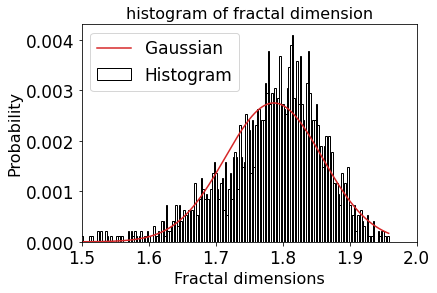

In [20]:
# Use this cell to make the plot
# YOUR CODE HERE
hist, edges = np.histogram(slopes, bins = int(len(slopes)/10))
centre = 0.5 * (edges[1:]+edges[0:-1])
widths = (edges[1:]-edges[0:-1])
hist   = hist / len(slopes) / widths 
mu=np.mean(slopes)
sig=np.std(slopes)
mu_error=sig/(np.sqrt(len(slopes)))
data=np.arange(min(slopes),max(slopes),(max(slopes)-min(slopes))/len(slopes))
gaussian = lambda i: (1/(sig*np.sqrt(2*np.pi)))*np.exp((-(i-mu)**2)/(2*sig**2))
gaussian_data = gaussian(data)
color = 'tab:red'

plt.plot(data,gaussian_data/len(data),label = 'Gaussian', color=color)
plt.bar(centre, hist/len(slopes), width=widths, align='center', facecolor="none",label='Histogram', edgecolor='black')
plt.xlabel(r'Fractal dimensions')
plt.ylabel(r'Probability')
plt.xlim(1.5,2,5)
plt.legend()
plt.title('histogram of fractal dimension')
print(round(mu,2),mu_error)

In [3]:
dimen=mywidgets.myFloatBox('Percolation','P1',r'$\langle d\rangle=$'
                           , 'Enter your estimate of the mean fractal dimension to three significant figures (5 marks)')
dimen.getWidget()


In [4]:
# display(HTML('<hr>'))

In [5]:
sigma=mywidgets.myFloatBox('Percolation','P2',r'$\sigma_{\langle d\rangle}=$'
                           , 'Enter your estimate of the error on the mean of the fractal dimension (5 marks)')
sigma.getWidget()


In [6]:
# display(HTML('<hr>'))

## b) The DLA model of cluster growth

Complete the DLA growth model in the `Cluster` class, using the course notes. 
In brief, the growth algorithm for a DLA cluster is as follows:

- create a cluster with a single seed at the centre, using the `Cluster` class you've developed
- choose an inner radius, $r_1$, and an edge radius $r_2$.
    - start a random walker from a location at distance close to $r_1$ from the seed, and let it walk
        - if it hits any part of the existing cluster, add its last location to the cluster, and start a new walk
        - if it crosses the outer boundary, $r>r_2$, terminate the random walk, and start a new walk
- terminate the run when the cluster contains a specified number of elements

In the cells below, $r_1$ is referred to as the "radius" and $r_2$ as the "edge".

You may want to base the random walk on the implementation you wrote in lecture 6 on random walks.
Use the cells below to verify some intermediate steps of this part of the assignment.

        
      

In [25]:
# create a cluster, and add a seed to the centre
size       = 101                  # the size here is only ever used for plotting
ndim       = 2                    # we only do the 2 dimensional case
periodic   = False                # non-periodic grid
cent       = int(size/2)          # put the seed in the center of the grid
seed       = (cent,) * ndim       # seed of cluster



Number of steps taken in this walk = 2072
Saving track to file:  Randomwalk.png


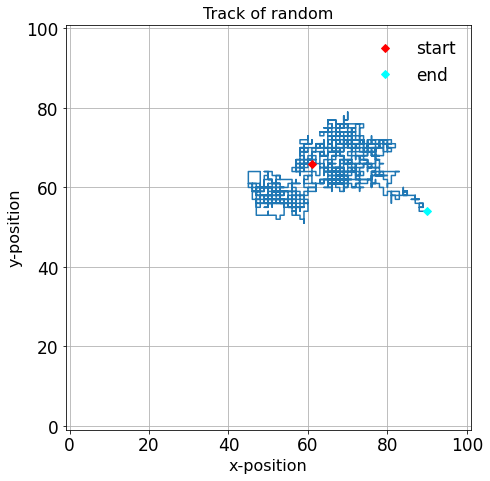

In [26]:
# as an example, perform a single walk to see what happens
centre = seed
radius = 20         # launch radius, r_1, for random walk
edge   = 40         # outer edge radius, r_2

# We specify a random number seed for this test, so you should always get the same shape of walk
dla = Cluster(ndim=ndim, size=size, random_number_seed=12, periodic=periodic)
dla.element_add(seed)
track    = dla.DLA(centre, radius, edge)
tracklen = len(track)
print('Number of steps taken in this walk = {}'.format(tracklen))
file   = "Randomwalk.png"  # name of the file to store the plot

# YOUR CODE HERE
### Nothing to implement: simply run this cell
# the call below plots the track the random walk followed, before it terminated
#     - either by travelling further than 'edge' from the seed
#     - or by hitting the seed
dla.ShowTrack(track, file=file)



You may want to compare your walk to the plot below. Your random walk should not look identical because it depends on the choice of seed for the random number dgenerator. If it looks *very* different you may have a bug somewhere in your code. 

Notice that in my case, the random walk terminates because it crosses the edge radius, $r_2$, and not because it hits the seed. If this happened when creating the DLA cluster, we would have to discard this walk and start a new one.

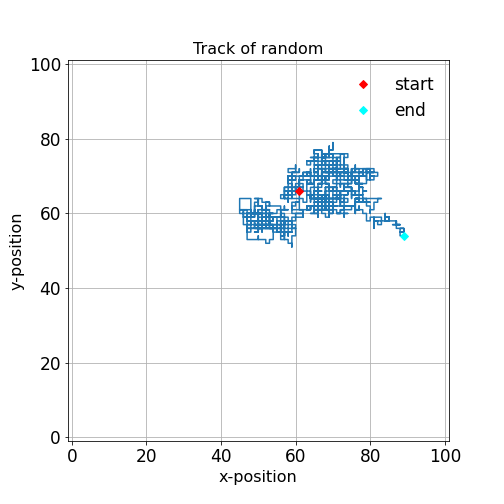

### Creating a DLA cluster

Use the random walk model to create a DLA cluster with `nel = 400` elements in it. If you're lucky, you'll have to perform 400 random walks befor the cluster has 400 elements. In practice, many walkers reach the edge before they hit the cluster, so you'll need to perform many more walks.

Use the cell below to plot the DLA cluster, saving the plot to a file.

Take care with the parameter ``radius`` and ``edge``. The values for these parameters in the cell below are reasonable initializations values from where to start the walk (at a distance `radius` from the centre of the DLA cluster), and for when to abort the random walk (if the walker ventures further than `edge` from the centre of the cluster). However, as the cluster grows in size, you will need to increase both `radius` and `edge`.

    - If radius is too small, the centre of the cluster will be too densely filled,
        since all walkers are started too close in.
    - If edge is too small, you again get a cluster that is too centrally concentrated.
    - If edge and/or radius are too large, then the code becomes very inefficient, because the walker can run everywhere with little chance of ever hitting the cluster.

Therefore, you may want to experiment with both these parameters, increasing them as the cluster grows in size.

Saving cluster to file:  DLA.png
 Calculation finished, cpu time used =  29.566945552825928


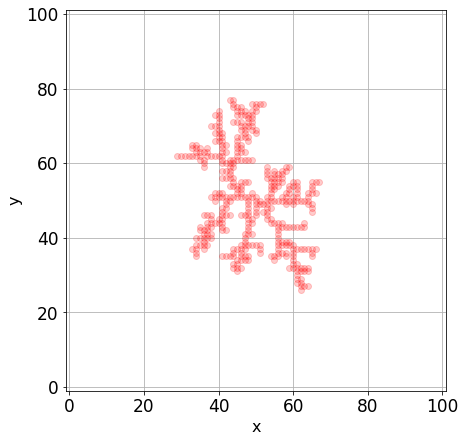

In [27]:
        
        
        
        
# Use this cell to compute the DLA cluster.

# These are the cluster's parameters
size     = 101                  # size of the grid is needed for plotting and setting the seed
cent     = int(size/2)          # set the seed
seed     = (cent,) * ndim       #
periodic = False                # non-periodic boundary conditions
dla      = Cluster(ndim=ndim, size=size, random_number_seed=12, periodic=periodic)
dla.element_add(seed)

# Approximate marking scheme: 
# DLA cluster looks OK: 3 marks
# axes are labelled:    2 marks

#  
centre = seed    # centre of the cluster
radius = 10      # start random walk at a distance of approximately 10 units from the centre
edge   = 20      # terminate walk if wanders further than edge units from the centre
nel    = 400     # terminate cluster growth if cluster contains nel elements

# Hint: to speed up the calculation, I found it useful
#   to set radius to radius = max([radius, 1.2 * rmax])
#       where radius is the previous radius
#             rmax is the maximum distance of a cluster element to the centre
#   to set edge to edge = max([edge, 1.7 * radius])
#       where edge is the previous value of the outer radius
#             radius is the current starting radius
#    This lets both the starting radius and the edge grow as the cluster grows in size

# YOUR CODE HERE
start_time = time.time()

for r in range(1000):
    rmax= max(dla.element_distances(centre).values())
    radius = max([radius, 1.2 * rmax])
    edge = max([edge, 1.7 * radius])
    track=dla.DLA(centre, radius,edge)
    

    if len(dla.grid.keys())==nel:#number of element
        break




# Use ShowCluster to visualize the cluster. Set cut=[-1, -1] to show the full 2D cluster
cut   = [-1, -1]
file  = 'DLA.png'
# YOUR CODE HERE
### Nothing to add - simply run this cell
title = 'DLA cluster'
dla.ShowCluster(cut, file=file)
cpu_time = time.time() - start_time
print(" Calculation finished, cpu time used = ", cpu_time)  

In [28]:
# fig, ax = plt.subplots(1, 1, figsize=(7,7))

# # compute distance of each element to seed
# distances = dla.element_distances(seed)
# dist      = np.asarray(list(distances.values()))

# # sort distances and ignore seed
# sort   = np.sort(dist)
# radius = sort[1:]
# mass   = 1 + np.arange(len(radius))

# # plot enclosed mass as a function of radius
# ax.plot(np.log10(radius), np.log10(mass), '.')
# ax.set_ylabel(r"$\log_{10} M(\leq r)$")
# ax.set_title('DLA: enclosed mass as a function of radius')

# # fit and over plot mass-radius relation
# mask = (radius > 1) & (radius < 10.)   # fit central part, avoiding very centre and outskirts
# slope, intercept, r, p, std_err = stats.linregress(np.log10(radius[mask]), np.log10(mass[mask]))
# info = r"slope = {0:2.2f} intercept = {1:2.2f}".format(slope, 10**intercept)
# print(info)
# lograds = np.arange(0, 1, 0.01)
# logm    = slope * lograds + intercept
# val     = 10**intercept
# label   = r"$M(\leq r)$ = {0:1.2f} $r^{{{1:1.2f}}}$".format(val, slope)
# ax.plot(lograds, logm, label=label)
# ax.set_ylim([1.01, 2.99])

# # annotations
# ax.set_xlim([0.45, 1.58])
# ax.set_xlabel(r"$\log_{10}(r)$")
# ax.legend(frameon=False)
# fig.tight_layout()
# fig.show()


You may want to compare your cluster to the plot below. Your cluster should not look identical, but if your cluster is much more concentrated for example, then there is likely something wrong in your implementation of DLA.

![DLAcluster_solution.png](attach![image.png](attachment:71d5ef50-e82c-4086-b690-93170b2d8d79.png)ment:DLAcluster_solution.png)

Now generate 50 DLA clusters with `nel=250` elements each. For each realisation, compte the enclosed mass as a function of radius, $M(\leq r)$, just as we did for the Eden case. Determine the fractal dimension, $d$, by fitting the relation $M(\leq r)\propto r^d$, over the radial range $r\in ]1, 10[$, as before.
This calculation may take some time to perform, around 10 minutes or so.

Compute the mean value of $d$, $\langle d\rangle$, and estimate the error on the mean.
Make a histogram of the values of $d$ for your 50 realisations, and over plot a Gaussian fit, indicating the mean.

Because the generation of the DLAs takes so long, you may want to use one cell to perform the calculation, and create one or more extra cells to compoute the statistics and make the plots.


In [29]:
# Use this cell to generate the 50 DLAs, and compute the fractal dimension for each.
# Make sure to save the values of the dimension, d, for all the runs, so you can make the histogram later.
# My calculation takes about 700 seconds to generate the 50 DLAs, requiring around 500 walkers per cluster.
# Hint: when implementing the code in this cell, you may want to generate fewer than 50 clusters
#   this way, you can test your code without having to wait a long time for the cell too complete
#   Once your are happy with your code, perform the final "production" calculation.
# YOUR CODE HERE
start_time = time.time()
size     = 101                
cent     = int(size/2)         
seed     = (cent,) * ndim       
periodic = False  
slopes2=[]
for i in range(50):
    dla      = Cluster(ndim=ndim, size=size, random_number_seed=i, periodic=periodic)
    dla.element_add(seed)
    centre = seed   
    radius = 10      
    edge   = 20      
    nel    = 250     
    origin2=list(dla.grid.keys())[0]

    for r in range(1000):
        rmax= max(dla.element_distances(centre).values())
        radius = max([radius, 1.2 * rmax])
        edge = max([edge, 1.7 * radius])
        track=dla.DLA(centre, radius,edge)
        if len(dla.grid.keys())==nel:
            break
    
    dist_ori2=list(dla.element_distances(origin2).values())
    dist_ori2.remove(0.0)
    dist_sorted2=sorted(dist_ori2)
    m2=[]
    temp2=[]
    for j in range(len(dist_sorted2)):
        m2.append(j+1)
    slo2=0
    c2=0
    x2=np.log10(dist_sorted2)
    y2=np.log10(m2)
    res2 = stats.linregress(x2, y2)
    slo2=res2.slope
    c2=res2.intercept
    slopes2.append(slo2)
slopes_a2 = np.asarray(slopes2)

cpu_time = time.time() - start_time
print(" Calculation finished, cpu time used = ", cpu_time)     

 Calculation finished, cpu time used =  789.6837174892426


1.5 0.011139606871035195


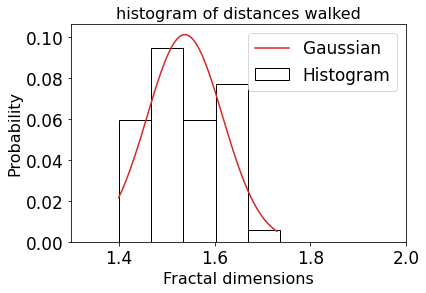

In [30]:
# Use this cell to generate compute and plot the histogram of d values, 
# and compute the requested statistical properties of the fractal dimensions.
# Hint: you may want to use stats.describe to compute statistical properties such as mean etc.


# approximate marking scheme
# plot is labelled:                        2 marks
# histogram of measured values looks OK:   4 marks
# Gaussian is over plotted and looks OK:   2 marks 
# Mean of The Gaussian is indicated:       2 marks

# YOUR CODE HERE
#print(slopes2)
hist, edges = np.histogram(slopes2, bins = int(len(slopes2)/10))
centre = 0.5 * (edges[1:]+edges[0:-1])
widths = (edges[1:]-edges[0:-1])
hist   = hist / len(slopes2) / widths 
mu=np.mean(slopes2)
sig=np.std(slopes2)
mu_error=sig/(np.sqrt(len(slopes2)))
data=np.arange(min(slopes2),max(slopes2),(max(slopes2)-min(slopes2))/len(slopes2))
gaussian = lambda i: (1/(sig*np.sqrt(2*np.pi)))*np.exp((-(i-mu)**2)/(2*sig**2))
gaussian_data = gaussian(data)
color = 'tab:red'

plt.plot(data,gaussian_data/len(data),label = 'Gaussian', color=color)
plt.bar(centre, hist/len(slopes2), width=widths, align='center', facecolor="none",label='Histogram', edgecolor='black')
plt.xlabel(r'Fractal dimensions')
plt.ylabel(r'Probability')
plt.xlim(1.3,2,3)
plt.legend()
plt.title('histogram of distances walked')
print(round(mu,1),mu_error)

In [7]:
dimenDLA=mywidgets.myFloatBox('Percolation','P3',r'$\langle d\rangle=$', 
                              'Enter your estimate of the mean fractal dimension to two significant figures (5 marks)')
dimenDLA.getWidget()


In [8]:
# display(HTML('<hr>'))

In [9]:
sigmaDLA=mywidgets.myFloatBox('Percolation','P4',r'$\sigma_{\langle d\rangle}=$'
                              , 'Enter your estimate of the error on the mean of the fractal dimension (5 marks)')
sigmaDLA.getWidget()


In [10]:
# display(HTML('<hr>'))

## c) Percolation

### Identifying a cluster

The cell below defines a class `GroupFinder` that identifies groups in a cluster.

The structure of the cluster required by GroupFinder is the same as what we had so far. The `Eden` cluster and the `DLA` cluster have the right format. Given a cluster, the groupfinder partitions the elements in a cluster by making sure that any two elements of the cluster that are nearest-neighbours, belong to the same group.

How to use the `GroupFinder` is explored in the following cells.




In [35]:
''' This class contains methods to
   - identify all groups in  a given cluster
        a group is a set of sites that are connected by mutual nearest-neighbours
   - examine whether a group percolates
 You should not have to edit any of these methods
 Use the cells below to learn how to use the method to identify groups, and examine percolation '''
class GroupFinder():
    # return a list of connected clusters
    def __init__(self, cluster):
        self.cluster = cluster
        # Each element within a group will point to a common element of the group - the head
        self.heads   = {}
        for element in self.cluster.grid:
            self.heads[element] = element  # initialize by assuming each element is in its own group
            
    # Iteratively loop over all elements in the cluster to identify groups
    def FoF(self):
        # Begin partitioning 
        #    We only loop over pairs of neighbours
        maxcount = 10000
        for element in self.cluster.grid:
            element_head = element
            count = 0
            while element_head != self.heads[element_head] and count < maxcount:
                element_head = self.heads[element_head]
            count = 0
            for neighbour in self.cluster.element_neighbours(element)[::2]:
                count = 0
                if neighbour in self.cluster.grid:
                    neighbour_head = neighbour
                    while neighbour_head != self.heads[neighbour_head] and count < maxcount:
                        count += 1
                        neighbour_head = self.heads[neighbour_head]
                    self.heads[neighbour_head] = element_head
            if count == maxcount:
                raise Exception("Error: partitioning does not converge")

        #
        count = 0
        for element in self.cluster.grid:
            element_head = element

            while element_head != self.heads[element_head] and count < maxcount:
                element_head = self.heads[element_head]
            self.heads[element] = element_head
        
        
        unique  = {}
        ngroups = 0
        for head in self.heads:
            if head not in unique:
                unique[head] = ngroups
                ngroups     += 1
        
        groupid = []
        for element in self.cluster.grid:
            groupid.append(unique[self.heads[element]])

        return np.asarray(groupid)

    # Alternative group finder   
    def Groups(self):
        groupid    = np.arange(len(self.cluster.grid), dtype=int)
        groupindx  = {}
        for index, element in enumerate(self.cluster.grid):
            groupindx[element] = index
        success = False
        count   = 0
        while not success:
            success = True
            for element in self.cluster.grid:
                for neighbour in self.cluster.element_neighbours(element):
                    if neighbour in self.cluster.grid:
                        indx1 = groupid[groupindx[element]]
                        indx2 = groupid[groupindx[neighbour]]
                        if indx1 < indx2:
                            groupid[groupid==indx2] = indx1
                            success = False
                            count += 1
                        elif indx1 > indx2:
                            groupid[groupid==indx1] = indx2
                            success = False
                            count += 1
            print(" count = ", count)
        return groupid

    # Examine the percolation of groups identified using a group finder
    # Loop over all unique groups in groupdid
    #     for each group, loop over all dimensions
    #     if a group percolates, store its id and the dimension that it percoaltes in
    #   return this to the calling routine
    def PercolateGrid(self, groupid):
        # determine whether thisgroup percolates
        
        # consistency: only works for non-periodic grids
        if self.cluster.periodic:
            raise Exception(" We only implement non-periodic grids ")
            
        #     
        groupindx  = {}
        for index, element in enumerate(self.cluster.grid):
            groupindx[element] = index
         
        # extract group by group
        result = []
        for group in np.unique(groupid):
            newcluster = Cluster(self.cluster.ndim, self.cluster.size, self.cluster.periodic)
            for element in self.cluster.grid:
                if groupid[groupindx[element]] == group:
                    newcluster.grid[element] = True 
                    
            # find whether this group percolates
            for dimen in range(self.cluster.ndim):
                if self.PercolateGroup(newcluster, dimen):
                    result.append([group, dimen])
        return result                
    
    # This method examines whether a given group percolates in a given dimension
    def PercolateGroup(self, cluster, dimen):
        # inputs:
        #    self: the class GroupFinder
        #    cluster: one of the groups identified by the group finder
        #    dimen: the dimension to check for percolation

        # consistency check
        if dimen < 0 or dimen >= cluster.ndim:
            raise Exception(" too many dimensions ")
        
        # Determine with this cluster touches both boundaries in dimension dimen of the dimensions simultaneously
        x = [sp[dimen] for sp in cluster.grid.keys()]
        return (min(x) == 0 and max(x) == cluster.size-1)

    ####### The routines below are useful for plotting groups #################
    def ExtractGroup(self, groupid, plotid, cut):
        groupindx  = {}
        for index, element in enumerate(self.cluster.grid):
            groupindx[element] = index
            
        newcluster = Cluster(self.cluster.ndim, self.cluster.size, self.cluster.periodic)
        for element in self.cluster.grid:
            if groupid[groupindx[element]] == plotid:
                newcluster.grid[element] = True
            
        xs, ys  = newcluster.ExtractSlice(cut)
        return xs, ys    
    
    def ShowGroup(self, groupid, plotid, cut):
        xs, ys = self.ExtractGroup(groupid, plotid, cut)
        ax.plot(xs, ys, 'o',alpha=0.2)[0]

   

### Examine the cell to see how the methods of GroupFinder and Cluster can be used to
 - create a cluster to work on
 - identify the groups inside the cluster
 - plot the result


group = 0 has id = 9969 and 1823 elements
group = 1 has id = 9990 and 2311 elements
group = 2 has id = 9999 and 3989 elements
group = 3 has id = 10001 and 1882 elements
Number of unique groups =  4
Number of elements in largest group =  3989


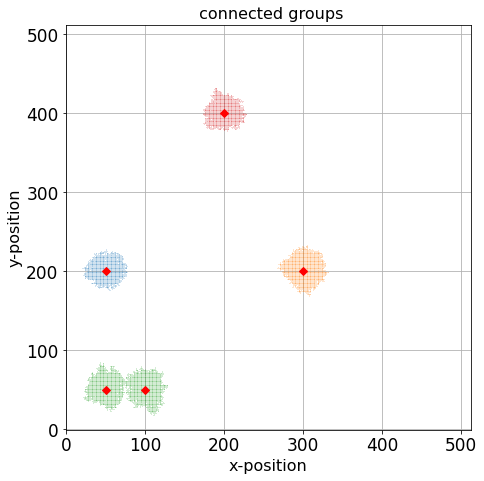

In [36]:
# set-up the grid parameters
size      = 512         # size of the lattice
ndim      = 2           # number of dimensions
periodic  = True        # periodic boundary conditions
rseed     = 12          # seed for random number generator
cluster   = Cluster(size=size, ndim=ndim, periodic=periodic, random_number_seed = rseed)

# Use the Eden model to grow some clusters on the lattice
#    starting seeds
seeds = ((50,50),(50,200),(100,50),(200,400),(300,200))
for seed in seeds:
    cluster.element_add(seed)    

# allow each cluster to grow
for i in range(10000):
    cluster.Eden()

# Now identify connected seeds
groupfinder = GroupFinder(cluster)

# Assign each element to its group. Elements of the same group have the same groupid
groupid     = groupfinder.FoF()
grouplen    = []

# Next, count the number of elements in each separate group
groups = np.arange(len(np.unique(groupid)))
for (id,group) in zip(np.unique(groupid), groups):
    count = len(np.where(groupid == id)[0])  # number of elements in this group
    grouplen.append(count)
    info = r"group = {0:1d} has id = {1:4d} and {2:3d} elements".format(group, id, count)
    print(info)
# Print some statistics    
print("Number of unique groups = ", len(np.unique(groupid)))
print("Number of elements in largest group = ", max(grouplen))

# Now plot all groups, identifiying different groups by their colour
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.set_aspect('equal')
ax.set_xlim(-1, cluster.size)
ax.set_ylim(-1, cluster.size)
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_title(' connected groups')
ax.grid()
for id in np.unique(groupid):
    xs, ys = groupfinder.ExtractGroup(groupid, id, cut)
    ax.plot(xs, ys, ',', alpha=0.2)[0]

# over plot the starting locations
for seed in seeds:
    x = seed[0]
    y = seed[1]
    ax.plot(x, y, 'D', color='red')
fig.tight_layout()
fig.show()

# Description: we grew Eden clusters starting from 5 different seed locations.
#   The seeds of these clusters are indicated with the red diamonds
# Running the group finder, we identified 4 separate groups - as you can see, the green group consists
#     of 2 Eden clusters that just touch - hence they form part of a single group

We will now use the group finder to study percolation.

Begin by examining the method `Random` in the class `Cluster`, which has as parameter $p$, in addition to size, ndim and periodic.  In this method, we generate a random number, $r$, for each grid point of square mesh, [size, size] in extent. If $r<p$, then we add this element to the cluster.

 generating sample grid with probability =  0.2  fraction of occupied elements=  0.1968
 generating sample grid with probability =  0.4  fraction of occupied elements=  0.3932
 generating sample grid with probability =  0.6  fraction of occupied elements=  0.5944


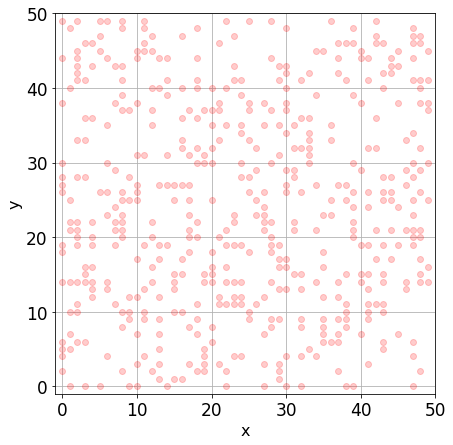

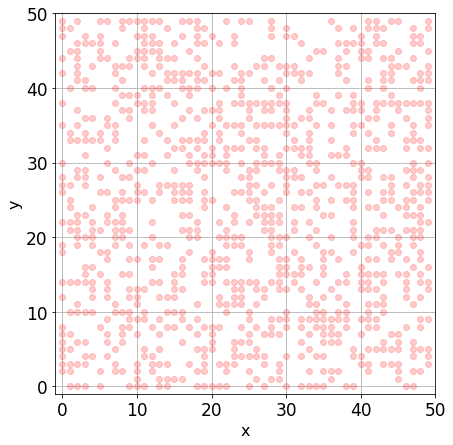

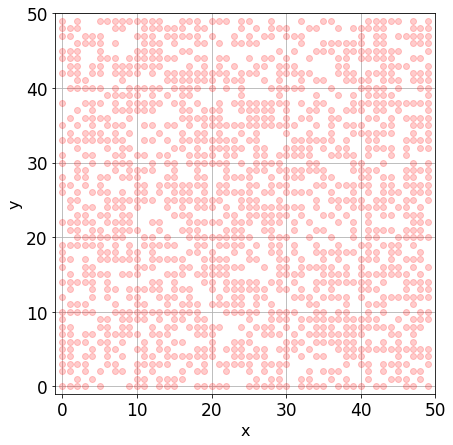

In [37]:
# Example of the method Cluster.Random for generating a cluster of points on a regular grid, with a given probability

size = 50         # size of the grid
ndim = 2          # dimensionality

# variable needed by ShowCluster
# cut = np.zeros(ndim)
# cut[0] = -1
# cut[1] = -1
# cut    = tuple(cut)
cut = [-1, -1]

# generate some with different probabilities as an example

# first example
probability = 0.2
cluster = Cluster(ndim=ndim, size=size, random_number_seed=1, periodic=False)
cluster.Random(probability)
fraction = len(cluster.grid) / float(size**ndim)
print(" generating sample grid with probability = ", probability," fraction of occupied elements= ", fraction)
cluster.ShowCluster(cut)

# second example
probability = 0.4
cluster = Cluster(ndim=ndim, size=size, random_number_seed=1, periodic=False)
cluster.Random(probability)
fraction = len(cluster.grid) / float(size**ndim)
print(" generating sample grid with probability = ", probability," fraction of occupied elements= ", fraction)
cluster.ShowCluster(cut)

# third example
probability = 0.6
cluster = Cluster(ndim=ndim, size=size, random_number_seed=1, periodic=False)
cluster.Random(probability)
fraction = len(cluster.grid) / float(size**ndim)
print(" generating sample grid with probability = ", probability," fraction of occupied elements= ", fraction)
cluster.ShowCluster(cut)




We now use the group finder to identify unique groups. As an example, we use the last cluster with $p=0.6$

Number of unique groups =  100
Biggest group =  610


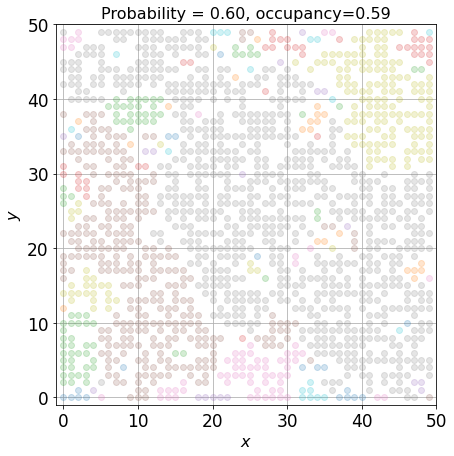

In [38]:
# we now use the group finder to identify clusters in the last last cluster as an example
groupfinder = GroupFinder(cluster)
groupid     = groupfinder.FoF()
grouplen    = []
for id in np.unique(groupid):
    grouplen.append(len(np.where(groupid == id)[0]))

print("Number of unique groups = ", len(np.unique(groupid)))
print("Biggest group = ", max(grouplen))

fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.set_aspect('equal')
ax.set_xlim(-1, cluster.size)
ax.set_ylim(-1, cluster.size)
ax.grid()
for id in np.unique(groupid):
    xs, ys = groupfinder.ExtractGroup(groupid, id, cut)
    ax.plot(xs, ys, 'o', alpha=0.2)[0]
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
occ  = len(cluster.grid) / float(size**ndim)
info = r"Probability = {0:1.2f}, occupancy={1:1.2f}".format(cluster.p, occ)
ax.set_title(info)
fig.show()    


Having played with random grids, and dividing a cluster into a set of connected groups, we will analyse
the appearance of a **percolating** cluster. A percolating cluster is **a group that touches both sides of the grid**
(either in the (horizontal) $x$-direction, or in the (vertical) $y$-direction). In the example above, you will see that the largest cluster percolates in both the vertical direction and the horizontal directions.

If the probability $p$ is small, then most clusters are small as well, and usually none of them percolates. If the probability $p$ is large, then there is usually one large cluster that percolates in either $x$ or $y$, or indeed in both directions.


As discussed in the lecture, the transition between these two regimes - no percolating cluster on average at low $p$, versus the presence of one or more percolating clusters, depends on the size of the grid, as well as on the value of $p$. Let $p_c$ be the characteristic value of $p$ where the transition happens. Operationally we will define $p_c$ as follows:

  - $p<p_c$: the average number of percolating clusters is < 50 per cent
  - $p>=p_c$: the average number of percolating clusters is >= 50 per cent

To determine the average, we need to generate many random grids with a given value of $p$.

Proceed as follows:

 - Generate a number of random clusters for a range of values of $p$. Set size=50, and ndim=2, periodic=False
 - For each cluster, identify the groups, and examine whether any of the groups percolates. Compute the fraction, $f_{\rm perc}$, of clusters with this value of $p$, that have (one or more) percolating groups
- Plot $f_{\rm perc}$ versus $p$ to estimate $p_c$.
- Reduce the range in $p$ to zoom in on $p_c$, and increase the number of clusters generated per $p$ value, to measure $p_c$ more accurately.
- Compute and report your value of $p_c$ to 3 significant figures

Because the generation of the random clusters takes time, you may want perform that calculation in one cell and save the results. Then create one or more cells to create the plots and do the analysis.

In [39]:
# Use this cell to zoom in on the calculation of $p_c$
# make sure the computation time does not exceed 6 minutes
# Hint: when implementing the code in this cell, you may once more start with fewer trial values
#   to speed-up the calculation. Then perform the production run. My code takes around 200 seconds
size = 50         # size of the grid
ndim = 2          # dimensionality

# You may want to use this set of values to evalaute the probability

# pcs is the set of values of the probability you may want to try
pnew   = np.arange(0.4,0.55, 0.05)
pcs    = pnew
pnew   = np.arange(0.56, 0.58, 0.01); pcs = np.concatenate((pcs, pnew))
pnew   = np.arange(0.580, 0.5815, 0.0003); pcs = np.concatenate((pcs, pnew))
pnew   = np.arange(0.582, 0.6, 0.01); pcs = np.concatenate((pcs, pnew))
pnew   = np.arange(0.6, 0.75, 0.05); pcs = np.concatenate((pcs, pnew))

# I experimented with the number of independent lattice to generate, for each p in pcs
# For example for small p (p=0.4, say), the fraction of realisations with a percolating cluster is very low
# In contrast for large p (p=0.75, say), most lattices contain a percolating cluster
# Therefore in those cases there is no need to generate many realisation (I used used 20) - the answer is pretty clear
# On the other hand, close to the critical value pc of p, you do need to generate many realisations 
#        to avoid the estimate being too noisy (I used 150)
# For intermediate values, you can use intermediate values of the number of realisations to try
#   You may want to try using a small number of realisations for all p first, and then up the number around
#   the critical value, pc.

# YOUR CODE HERE
start_time = time.time()
Percol_pc={}
P_error={}
uni={}
for i in range(150):
    Frac=[]
    error=[]
    for pc in pcs:
        probability = pc
        cluster = Cluster(ndim=ndim, size=size, random_number_seed=i, periodic=False)
        cluster.Random(probability)
     
        groupfinder = GroupFinder(cluster)
        groupid     = groupfinder.FoF()
        grouplen    = []
        for id in np.unique(groupid):
            grouplen.append(len(np.where(groupid == id)[0]))
        #Percol_pc[pc]=groupfinder.PercolateGrid(groupid)
        percentage_pc=max(grouplen)/sum(grouplen)
        Frac.append(percentage_pc)
        error.append(np.sqrt(max(grouplen))/(probability*float(size**ndim)))
        P_error[i]=error
    uni[i]=[pcs,Frac]

cpu_time = time.time() - start_time
print(" Calculation finished, cpu time used = ", cpu_time)  

 Calculation finished, cpu time used =  240.31918668746948


Pc 0.593


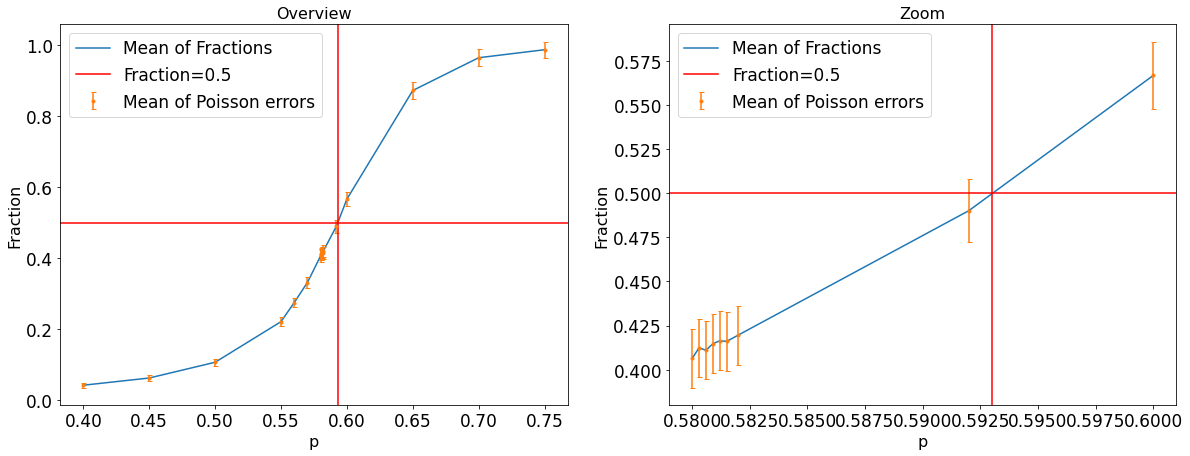

In [40]:
# Use this cell to plot the fraction of realisation that have a percolating cluster,  
#     as a function of the probability, p.
# Also use it to compute your estimate of the value of p=p_c, i.e. where the fraction is 50 per cent

# Plot two panels: 
#    left panel shows an overview (large range in p)
#    right panels zooms in on the characteristic value pc.
#    estimate and overplot the error (uncertainty) in the average
# Indicate your estimate of (pc, 0.5)

# Approximate marking scheme:
# two plots with axes labels:                          2 marks
# plots show fraction as a function of p, and look OK: 4 marks
# value of (pc, 50%) is clearly indicated:             2 marks
# Poisson errors are over plotted:                     2 marks

# YOUR CODE HERE
fig, ax = plt.subplots(1, 2, figsize=(20,7))
#for k in range(len(uni)): 
    #for i in range(len(pcs)):
        #ax[0].scatter(pcs[i],list(uni.values())[k][1][i])
ys=[]
for i in range(len(pcs)): 
    y=[]
    for k in range(len(uni)):
        y.append(list(uni.values())[k][1][i])
    ys.append(np.mean(y))  

pcss=pcs[6:15]
sl_flac={}
yss=ys[6:15]
errs=[]
for o in range(len(pcs)):
    err=[]
    for p in range(len(P_error)):
        err.append(list(P_error.values())[p][o])
    errs.append(np.mean(err))
lerrs=errs[6:15]
for i in range(len(list(uni.values()))):
    sl_flac[i]=list(uni.values())[i][1][6:15]
#for j in range(len(pcss)):
    #for l in range(len(sl_flac)):
        #ax[1].scatter(pcss[j],sl_flac[l][j])

ax[0].plot(pcs,ys, label = 'Mean of Fractions')        
ax[1].plot(pcss,yss, label = 'Mean of Fractions')
ax[0].errorbar(pcs,ys, label = 'Mean of Poisson errors', yerr=errs,fmt='.',capsize=2.5)
ax[1].errorbar(pcss,yss, label = 'Mean of Poisson errors', yerr=lerrs,fmt='.',capsize=2.5)
ax[0].axhline(y=0.5,label = 'Fraction=0.5', color='r', linestyle='-')
ax[1].axhline(y=0.5,label = 'Fraction=0.5', color='r', linestyle='-')
ax[0].set_xlabel(r'p')
ax[0].set_ylabel(r'Fraction')
ax[0].set_title('Overview')
ax[1].set_xlabel(r'p')
ax[1].set_ylabel(r'Fraction')
ax[1].set_title('Zoom')
ax[0].legend()
ax[1].legend()
PC=((0.5-yss[-2])*(pcss[-1]-pcss[-2])/(yss[-1]-yss[-2]))+pcss[-2]# To find Pc it interpolate
ax[0].axvline(x=PC, ymin=0, ymax=1, color='red') 
ax[1].axvline(x=PC, ymin=0, ymax=1, color='red')
print('Pc',round(PC,3))



In [11]:
perc=mywidgets.myFloatBox('Percolation','P5','$p_c$ ='
                          , 'Enter your estimate of the critical value $p_c$ to at least three significant figures (5 marks)')
perc.getWidget()


## End of the assignment.

Well done. Make sure that your notebook validates before making the final submission.